In [ ]:
import torch

Labels_train_tensor = torch.load('/content/drive/My Drive/dataset/FactValidation/Labels_train.pt')
Labels_test_tensor = torch.load('/content/drive/My Drive/dataset/FactValidation/Labels_test.pt')
Labels_val_tensor = torch.load('/content/drive/My Drive/dataset/FactValidation/Labels_val.pt')

Data_train_tensor_claims = torch.load('/content/drive/My Drive/dataset/Data_train_tensor_claims.pt')
Data_test_tensor_claims = torch.load('/content/drive/My Drive/dataset/Data_test_tensor_claims.pt')
Data_val_tensor_claims = torch.load('/content/drive/My Drive/dataset/Data_val_tensor_claims.pt')

Data_train_tensor_evidences = torch.load('/content/drive/My Drive/dataset/Data_train_tensor_evidences.pt')
Data_test_tensor_evidences = torch.load('/content/drive/My Drive/dataset/Data_test_tensor_evidences.pt')
Data_val_tensor_evidences = torch.load('/content/drive/My Drive/dataset/Data_val_tensor_evidences.pt')

In [ ]:
#https://gist.github.com/spro/c87cc706625b8a54e604fb1024106556
#https://stackoverflow.com/a/60591445/13858569
import torch.nn as nn
import math

def calc_shape(L_in, conv, pool):

  #default values
  def_conv_padding = 0
  def_conv_stride = 1
  def_pool_padding = 0

  for i in range(len(conv)) :

    L_in = math.floor( ( (L_in + (2*def_conv_padding) - conv[i] ) / def_conv_stride) + 1 )
    def_pool_stride = pool[i] #default MaxPool1D stride is kernel size
    L_in = math.floor( ( (L_in + (2*def_pool_padding) - pool[i] ) / def_pool_stride) + 1 )
  
  return(L_in)


class CNNClassifer(nn.Module):
    
    #define all the layers used in model
    def __init__(self, num_classes = 3, 
                 embedding_dim = 768,
                 seq_length = 128,
                 conv_kernel_sizes = [2,1],
                 pool_kernel_sizes = [2,2],
                 out_channels = [10,10],
                 hidden_size1 = 128, hidden_size2 = 128,
                 dropout = 0.1):
        
        super(CNNClassifer, self).__init__()        
        
        self.conv1 = nn.Conv1d(in_channels = embedding_dim, out_channels = out_channels[0], kernel_size = conv_kernel_sizes[0])
        self.pool1 = nn.MaxPool1d(kernel_size = pool_kernel_sizes[0])

        self.conv2 = nn.Conv1d(in_channels = out_channels[0], out_channels = out_channels[1], kernel_size = conv_kernel_sizes[1])
        self.pool2 = nn.MaxPool1d(kernel_size = pool_kernel_sizes[1])

        self.fc_input_size = calc_shape(seq_length, conv = conv_kernel_sizes, pool = pool_kernel_sizes)

        self.fc1 = nn.Linear(out_channels[-1]*self.fc_input_size*2, hidden_size1) #no. of output channels of last conv layer * last dimension of output from conv-maxpool layers * 2 for each claims and evidences embeddings
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.out = nn.Linear(hidden_size2, num_classes)

        self.dropout = nn.Dropout(dropout)
        self.softmax = torch.nn.Softmax()
        self.relu = nn.ReLU()
        
    def forward(self, claims_embedding, evidences_embedding):
      
        #Generated embeddings are of the shape [batch_size, seq_length, embedding_size]
        #Input to conv1D will be [batch_size, embedding_size, seq_length], thus, need to transpose

        claims_embedding = claims_embedding.transpose(1,2)
        evidences_embedding = evidences_embedding.transpose(1,2)

        # claims
        x1 = self.relu(self.conv1(claims_embedding)) 
        x1 = self.pool1(x1)
        x1 = self.relu(self.conv2(x1))
        x1 = self.pool2(x1)
        x1 = x1.flatten(1) #converting 3D tensor to 2D to concat


        # evidences
        x2 = self.relu(self.conv1(evidences_embedding)) 
        x2 = self.pool1(x2)
        x2 = self.relu(self.conv2(x2))
        x2 = self.pool2(x2)
        x2 = x2.flatten(1) #converting 3D tensor to 2D to concat

        
        x = torch.cat((x1,x2),dim=1)


        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.out(x)

        
        if(self.training) :
            return x
        else :
            output = self.softmax(x)
            return output

In [ ]:
import torch
##from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
from torch.optim import AdamW
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import time
import datetime


class Train_Test():

    def __init__(self, Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor, 
                 Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor, 
                 Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor,
                 hidden_layer_size = 512, batch_size = 32, epochs = 10, learning_rate = 2e-5, dropout = 0.1):


      self.model = CNNClassifer().cuda()
      self.batch_size = batch_size
      self.learning_rate = learning_rate
      self.epochs = epochs
      self.optimizer = self.SetOptimizer()
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.epoch_loss_set = []
      self.train_dataloader = self.SetTrainDataloader(Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor)
      self.test_dataloader = self.SetTestDataloader(Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor) 
      #self.scheduler = self.SetScheduler()
      self.val_accuracy_set = [] 
      self.val_dataloader = self.SetValDataloader(Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor)
      self.class_wise_metrics = None
      self.results = pd.DataFrame(0, index=['metrics'], columns=['Accuracy','Precision','Recall','F_Score']).astype(float)


    def SetOptimizer(self) :

      optimizer = AdamW(self.model.parameters(), self.learning_rate, eps = 1e-6)
      return(optimizer)

    
    '''
    def SetScheduler(self) :

      scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps = 10, 
                                                  num_training_steps = self.epochs*len(self.train_dataloader))
      return(scheduler) 
    '''




    def Get_Metrics(self, actual, predicted) :

      self.results['Accuracy'] += metrics.accuracy_score(actual, predicted)
      #self.results['Recall'] += metrics.recall_score(actual, predicted, average='micro')
      #self.results['Precision'] += metrics.precision_score(actual, predicted, average='micro')
      #self.results['F_Score'] += metrics.f1_score(actual, predicted, average='micro')

 
 
    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def Plot_Training_Epoch_Loss(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.epoch_loss_set, 'b-o')
      plt.title("Training loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.savefig('Training_Epoch_Loss.png',bbox_inches='tight')
      plt.show()

    
    def Plot_Training_Epoch_Accuracy(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.val_accuracy_set, 'b-o')
      #plt.title("Micro F1 Score") 
      plt.xlabel("Epoch")
      plt.ylabel("Validation Accuracy")
      plt.savefig('Training_Validation_Accuracy.png',bbox_inches='tight')
      plt.show()


    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def format_time(self, elapsed):
      '''
      Takes a time in seconds and returns a string hh:mm:ss
      '''
      # Round to the nearest second.
      elapsed_rounded = int(round((elapsed)))
      return str(datetime.timedelta(seconds=elapsed_rounded))


    def SetTrainDataloader(self, Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor) :

      train_dataset = TensorDataset(Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size = self.batch_size)
      return(train_dataloader)


    def SetTestDataloader(self, Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor) :
      
      test_dataset = TensorDataset(Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor)
      test_sampler = SequentialSampler(test_dataset)
      test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = Data_test_tensor_claims.shape[0])
      return(test_dataloader)

    
    def SetValDataloader(self, Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor) :
      
      val_dataset = TensorDataset(Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor)
      val_sampler = SequentialSampler(val_dataset)
      val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size = Data_val_tensor_claims.shape[0])
      return(val_dataloader)

   
    def Train(self) :

      for _ in trange(self.epochs, desc="Epoch"):
        
        self.model.train()
        epoch_loss = 0

        # Measure how long the training epoch takes.
        t0 = time.time()
    
        for step_num, batch_data in enumerate(self.train_dataloader):

          # Progress update every 30 batches.
          if step_num % 30 == 0 and not step_num == 0:
            elapsed = self.format_time(time.time() - t0)
            print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

          samples_claims, samples_evidences, labels = tuple(t.to(self.device) for t in batch_data)
          self.optimizer.zero_grad()
          predictions = self.model(samples_claims, samples_evidences)
          loss_fct = nn.CrossEntropyLoss()
          batch_loss = loss_fct(predictions, labels)
          batch_loss.backward()
          self.optimizer.step()
          #self.scheduler.step()
          epoch_loss += batch_loss.item()

        avg_epoch_loss = epoch_loss/len(self.train_dataloader)
        print("\nTrain loss for epoch: ",avg_epoch_loss)
        print("\nTraining epoch took: {:}".format(self.format_time(time.time() - t0)))
        self.epoch_loss_set.append(avg_epoch_loss)

        
        #Validation on the epoch
        self.model.eval()
        epoch_accu_score = 0

        for batch_data in self.val_dataloader:
          samples_claims, samples_evidences, labels = tuple(t.to(self.device) for t in batch_data)
          with torch.no_grad():
            output = self.model(samples_claims, samples_evidences)

          #threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
          #predictions = (output > threshold).int()

          predictions = torch.argmax(output,dim=1).to('cpu').numpy()
          labels = labels.to('cpu').numpy()
      
          accu_score = metrics.accuracy_score(labels, predictions)
          epoch_accu_score += accu_score

        avg_accu_score = epoch_accu_score/len(self.val_dataloader)
        print("\n Accuracy score for epoch: ",avg_accu_score,"\n")
        self.val_accuracy_set.append(avg_accu_score)

      torch.save(self.model.state_dict(), "/content/drive/My Drive/dataset/model.pt")
      self.Plot_Training_Epoch_Loss()
      self.Plot_Training_Epoch_Accuracy()
      
   

    def Test(self) :

      # Put model in evaluation mode to evaluate loss on the test set
      self.model.eval()

      for batch_data in self.test_dataloader:
  
        samples_claims, samples_evidences, labels = tuple(t.to(self.device) for t in batch_data)
      
        with torch.no_grad():
          output = self.model(samples_claims, samples_evidences)

        predictions = torch.argmax(output,dim=1).to('cpu').numpy()
        labels = labels.to('cpu').numpy()      
      
        self.Get_Metrics(labels, predictions)
        ##self.class_wise_metrics = metrics.classification_report(labels, predictions, target_names= list(self.label_names))
        
    
      self.results = self.results/len(self.test_dataloader)
      #print("Test data metrics : \n")

      
      return(self.results)




Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:   2%|▏         | 1/50 [00:01<00:53,  1.08s/it]


Train loss for epoch:  1.0790326896466707

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.4398216939078752 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:   4%|▍         | 2/50 [00:02<00:52,  1.09s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.9703137987538388

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5156017830609212 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:   6%|▌         | 3/50 [00:03<00:51,  1.09s/it]


Train loss for epoch:  0.8660726161379563

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5289747399702823 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:   8%|▊         | 4/50 [00:04<00:50,  1.09s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.8287281318714744

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5349182763744428 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  10%|█         | 5/50 [00:05<00:49,  1.09s/it]


Train loss for epoch:  0.7989037516869997

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5542347696879644 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  12%|█▏        | 6/50 [00:06<00:47,  1.09s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.7726775360734839

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5393759286775631 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  14%|█▍        | 7/50 [00:07<00:46,  1.09s/it]


Train loss for epoch:  0.7442714201776605

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5676077265973254 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  16%|█▌        | 8/50 [00:08<00:45,  1.09s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.7216036705594314

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5809806835066865 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  18%|█▊        | 9/50 [00:09<00:44,  1.09s/it]


Train loss for epoch:  0.7011962840431615

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.563150074294205 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  20%|██        | 10/50 [00:10<00:43,  1.09s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.6815022735219253

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5884101040118871 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  22%|██▏       | 11/50 [00:11<00:42,  1.09s/it]


Train loss for epoch:  0.6566311993097004

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.586924219910847 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  24%|██▍       | 12/50 [00:13<00:41,  1.09s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.6344194953378878

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5973254086181278 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  26%|██▌       | 13/50 [00:14<00:40,  1.08s/it]


Train loss for epoch:  0.6047322070912311

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5958395245170877 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  28%|██▊       | 14/50 [00:15<00:38,  1.08s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.5942503568373229

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.600297176820208 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  30%|███       | 15/50 [00:16<00:37,  1.07s/it]


Train loss for epoch:  0.5754566556528995

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.600297176820208 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  32%|███▏      | 16/50 [00:17<00:36,  1.07s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.5551556259393692

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6136701337295691 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  34%|███▍      | 17/50 [00:18<00:35,  1.07s/it]


Train loss for epoch:  0.5182860393273203

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6106983655274889 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  36%|███▌      | 18/50 [00:19<00:34,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.5071750445585502

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6210995542347697 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  38%|███▊      | 19/50 [00:20<00:32,  1.06s/it]


Train loss for epoch:  0.5170179765475423

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.612184249628529 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  40%|████      | 20/50 [00:21<00:31,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.4861613670462056

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6136701337295691 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  42%|████▏     | 21/50 [00:22<00:30,  1.06s/it]


Train loss for epoch:  0.46728479462234596

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5973254086181278 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  44%|████▍     | 22/50 [00:23<00:29,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.4629155046845737

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6047548291233283 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  46%|████▌     | 23/50 [00:24<00:28,  1.06s/it]


Train loss for epoch:  0.43614886457982815

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.612184249628529 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  48%|████▊     | 24/50 [00:25<00:27,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.42118397174697175

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6077265973254086 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  50%|█████     | 25/50 [00:26<00:26,  1.06s/it]


Train loss for epoch:  0.40696109007847936

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6077265973254086 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  52%|█████▏    | 26/50 [00:27<00:25,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.41848778246264706

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6077265973254086 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  54%|█████▍    | 27/50 [00:29<00:24,  1.06s/it]


Train loss for epoch:  0.40329949981287905

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6106983655274889 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  56%|█████▌    | 28/50 [00:30<00:23,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.3789757028222084

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5958395245170877 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  58%|█████▊    | 29/50 [00:31<00:22,  1.06s/it]


Train loss for epoch:  0.4131999821255082

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6032689450222882 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  60%|██████    | 30/50 [00:32<00:21,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.356870784414442

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6077265973254086 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  62%|██████▏   | 31/50 [00:33<00:20,  1.06s/it]


Train loss for epoch:  0.3550172957934831

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5854383358098069 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  64%|██████▍   | 32/50 [00:34<00:19,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.35225241544999575

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6181277860326895 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  66%|██████▌   | 33/50 [00:35<00:18,  1.06s/it]


Train loss for epoch:  0.3640550167152756

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6047548291233283 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  68%|██████▊   | 34/50 [00:36<00:16,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.33803920663501086

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5943536404160475 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  70%|███████   | 35/50 [00:37<00:15,  1.06s/it]


Train loss for epoch:  0.32717726371790234

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6151560178306092 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  72%|███████▏  | 36/50 [00:38<00:14,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.33581722331674474

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6151560178306092 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  74%|███████▍  | 37/50 [00:39<00:13,  1.06s/it]


Train loss for epoch:  0.3159777098188275

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6092124814264487 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  76%|███████▌  | 38/50 [00:40<00:12,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.32287923889724834

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.600297176820208 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  78%|███████▊  | 39/50 [00:41<00:11,  1.08s/it]


Train loss for epoch:  0.30345616411221654

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.586924219910847 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  80%|████████  | 40/50 [00:42<00:10,  1.08s/it]


Train loss for epoch:  0.29071539271818964

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6166419019316494 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  82%|████████▏ | 41/50 [00:43<00:09,  1.07s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.2817817334281771

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.6047548291233283 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  84%|████████▍ | 42/50 [00:45<00:08,  1.07s/it]


Train loss for epoch:  0.2827037862453021

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5943536404160475 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  86%|████████▌ | 43/50 [00:46<00:07,  1.07s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.281529520412809

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5973254086181278 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  88%|████████▊ | 44/50 [00:47<00:06,  1.07s/it]


Train loss for epoch:  0.2604136444236103

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5988112927191679 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:01
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  90%|█████████ | 45/50 [00:48<00:05,  1.07s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.24813473838332453

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.600297176820208 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  92%|█████████▏| 46/50 [00:49<00:04,  1.07s/it]


Train loss for epoch:  0.2781142808496952

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.612184249628529 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  94%|█████████▍| 47/50 [00:50<00:03,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.26156938826959386

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5854383358098069 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch:  96%|█████████▌| 48/50 [00:51<00:02,  1.06s/it]


Train loss for epoch:  0.2644241298695928

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5809806835066865 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01




Epoch:  98%|█████████▊| 49/50 [00:52<00:01,  1.06s/it]

  Batch :  180  , Time elapsed :  0:00:01

Train loss for epoch:  0.2714471044509034

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5973254086181278 

  Batch :  30  , Time elapsed :  0:00:00
  Batch :  60  , Time elapsed :  0:00:00
  Batch :  90  , Time elapsed :  0:00:00
  Batch :  120  , Time elapsed :  0:00:01
  Batch :  150  , Time elapsed :  0:00:01
  Batch :  180  , Time elapsed :  0:00:01




Epoch: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Train loss for epoch:  0.24531019182973787

Training epoch took: 0:00:01

 Accuracy score for epoch:  0.5913818722139673 



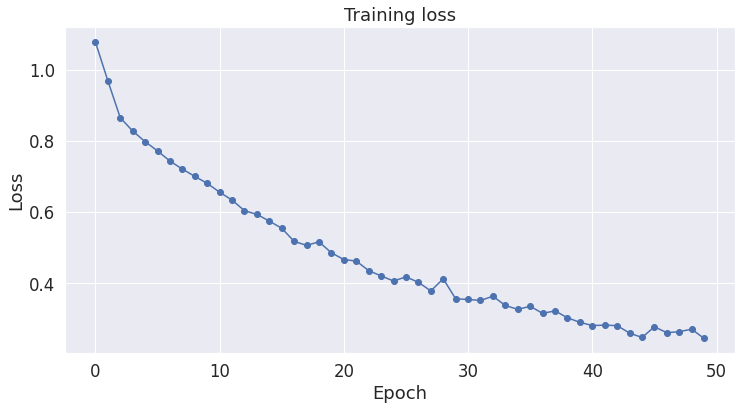

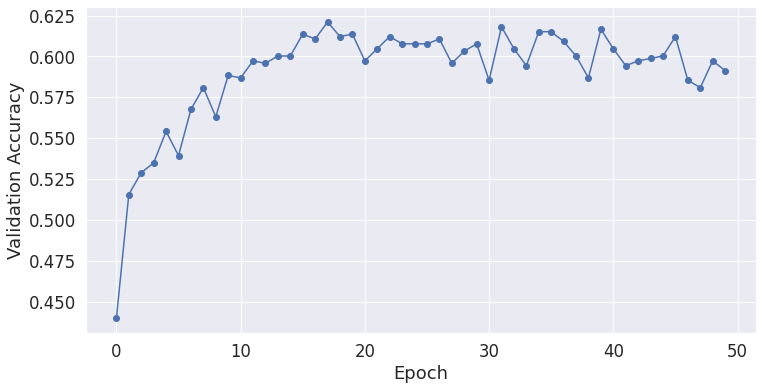

,Accuracy,Precision,Recall,F_Score
metrics,0.61022,0.0,0.0,0.0


In [ ]:
train_test = Train_Test(Data_train_tensor_claims, Data_train_tensor_evidences, Labels_train_tensor, 
                 Data_test_tensor_claims, Data_test_tensor_evidences, Labels_test_tensor, 
                 Data_val_tensor_claims, Data_val_tensor_evidences, Labels_val_tensor,
                 hidden_layer_size = 256, batch_size = 32, epochs = 50, learning_rate = 0.005, dropout = 0.2)
train_test.Train()
train_test.Test()

In [ ]:
'''import pandas as pd
dataset_embeddings = pd.read_pickle('/content/drive/My Drive/dataset/fact_validation_dataset.pkl')

import torch
from sklearn.model_selection import train_test_split

def Train_Test_Val_Split(data , test_data_fraction = 0.2, val_data_fraction = 0.1) :
    
    Data_train, Data_test, Labels_train, Labels_test = train_test_split(data, list(data['Labels']), test_size = test_data_fraction)
    Data_train, Data_val, Labels_train, Labels_val = train_test_split(Data_train, Labels_train, test_size = val_data_fraction)

    Labels_train = torch.tensor(Labels_train)
    Labels_test = torch.tensor(Labels_test)
    Labels_val = torch.tensor(Labels_val)

    Data_train = Data_train.reset_index(drop=True)
    Data_test = Data_test.reset_index(drop=True)
    Data_val = Data_val.reset_index(drop=True)
    

    return (Data_train, Data_test, Data_val, Labels_train, Labels_test, Labels_val)
    
Data_train, Data_test, Data_val, Labels_train_tensor, Labels_test_tensor, Labels_val_tensor = Train_Test_Val_Split(dataset_embeddings)

Data_train_tensor_claims = torch.tensor(Data_train['Claims'])
Data_test_tensor_claims = torch.tensor(Data_test['Claims'])
Data_val_tensor_claims = torch.tensor(Data_val['Claims'])

Data_train_tensor_evidences = torch.tensor(Data_train['Evidences'])
Data_test_tensor_evidences = torch.tensor(Data_test['Evidences'])
Data_val_tensor_evidences = torch.tensor(Data_val['Evidences'])'''